# Compute correlations in longitude bins with no regime averaging

In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [ ]:
client = Client()
client

## Load u_along and CSHT if you want to compute correlations from scratch:
Note if these are already calculated, there is section below that opens the already saved correlations and analyses them.

In [3]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc')

# resample monthly:
u_along_da_months = u_along.resample(time='1M').mean()#.U_along_contour_binned
u_along_da_months = u_along_da_months.sel(potrho0=slice(13.8,28.42))#.rename({'lon_bin_midpoints': 'lon'})
u_along_da_months.load();

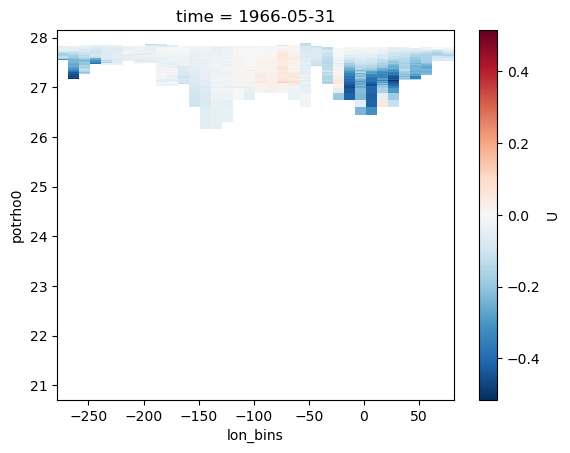

In [4]:
u_along_da_months.isel(time = 100).U.plot()

In [5]:
# Load CSHT field
CSHT_along = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc')

# resample monthly:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()


In [6]:
# monthly water mass mask 
age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')
age_mask

<xarray.Dataset> Size: 68MB
Dimensions:    (potrho0: 108, time: 732, lon_bins: 36)
Coordinates:
  * potrho0    (potrho0) float64 864B 21.5 23.07 23.22 ... 28.13 28.14 29.08
  * time       (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * lon_bins   (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
Data variables:
    AASW_mask  (time, potrho0, lon_bins) float64 23MB dask.array<chunksize=(732, 108, 36), meta=np.ndarray>
    CDW_mask   (time, potrho0, lon_bins) float64 23MB dask.array<chunksize=(732, 108, 36), meta=np.ndarray>
    DSW_mask   (time, potrho0, lon_bins) float64 23MB dask.array<chunksize=(732, 108, 36), meta=np.ndarray>

In [7]:

CSHT_months_binned_CDW = (age_mask.CDW_mask * CSHT_along_monthly )
CSHT_months_binned_AASW = (age_mask.AASW_mask * CSHT_along_monthly )
u_along_da_months_binned_CDW = (age_mask.CDW_mask *u_along_da_months)
u_along_da_months_binned_AASW = (age_mask.AASW_mask *u_along_da_months)

#CSHT_months_binned = CSHT_along_monthly 
#u_along_da_months_binned = u_along_da_months

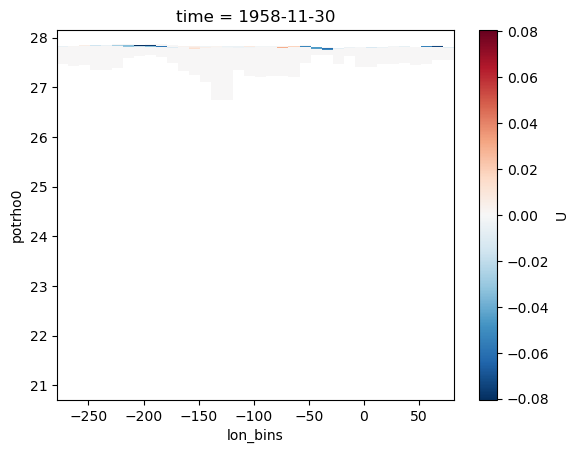

In [8]:
u_along_da_months_binned_CDW.isel(time = 10).U.plot()

In [9]:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')
vol_bins

<xarray.Dataset> Size: 23MB
Dimensions:   (potrho0: 108, time: 732, lon_bins: 36)
Coordinates:
  * potrho0   (potrho0) float64 864B 21.5 23.07 23.22 ... 28.13 28.14 29.08
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
Data variables:
    volume    (time, potrho0, lon_bins) float64 23MB dask.array<chunksize=(732, 108, 36), meta=np.ndarray>

## Do different time averaging to compute correlations on different time scales:

In [10]:
## Average over different time scales to get depth-based correlations - but already seperating into water masses 
## in anticipation of correlation

CSHT_annual_binned_CDW = CSHT_months_binned_CDW.groupby('time.year').mean('time').sum(dim = 'potrho0')
U_along_annual_binned_CDW = u_along_da_months_binned_CDW.groupby('time.year').mean('time').mean(dim = 'potrho0')

CSHT_layerwise_binned_CDW = CSHT_months_binned_CDW.sum(dim = 'potrho0')
U_along_layerwise_binned_CDW = u_along_da_months_binned_CDW.mean(dim = 'potrho0')

CSHT_annual_binned_AASW = CSHT_months_binned_AASW.groupby('time.year').mean('time').sum(dim = 'potrho0')
U_along_annual_binned_AASW = u_along_da_months_binned_AASW.groupby('time.year').mean('time').mean(dim = 'potrho0')

CSHT_layerwise_binned_AASW = CSHT_months_binned_AASW.sum(dim = 'potrho0')
U_along_layerwise_binned_AASW = u_along_da_months_binned_AASW.mean(dim = 'potrho0')
U_along_layerwise_binned_AASW

<xarray.Dataset> Size: 217kB
Dimensions:   (lon_bins: 36, time: 732)
Coordinates:
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
  * time      (time) datetime64[ns] 6kB 1958-01-31 1958-02-28 ... 2018-12-31
Data variables:
    U         (time, lon_bins) float64 211kB dask.array<chunksize=(732, 36), meta=np.ndarray>

In [11]:
n_bins = len(vol_bins.lon_bins)

In [12]:
def vol_ave_potrho0_potmask(quantity,vol_bins):
    return (quantity * vol_bins.volume).mean('potrho0')/vol_bins.mean('potrho0').volume

In [13]:
## with volume averaging for U
U_along_annual_binned_CDW_volav = vol_ave_potrho0_potmask(u_along_da_months_binned_CDW,vol_bins).groupby('time.year').mean('time')
U_along_layerwise_binned_CDW_volav = vol_ave_potrho0_potmask(u_along_da_months_binned_CDW,vol_bins)
U_along_annual_binned_AASW_volav = vol_ave_potrho0_potmask(u_along_da_months_binned_AASW,vol_bins).groupby('time.year').mean('time')
U_along_layerwise_binned_AASW_volav = vol_ave_potrho0_potmask(u_along_da_months_binned_AASW,vol_bins)

In [14]:
U_along_annual_binned_CDW_volav

<xarray.Dataset> Size: 18kB
Dimensions:   (year: 61, lon_bins: 36)
Coordinates:
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
  * year      (year) int64 488B 1958 1959 1960 1961 1962 ... 2015 2016 2017 2018
Data variables:
    U         (year, lon_bins) float64 18kB dask.array<chunksize=(61, 36), meta=np.ndarray>

In [15]:
# climatology

In [16]:
CSHT_binned_CDW =  (age_mask.CDW_mask *CSHT_along_monthly)
CSHT_binned_AASW =  (age_mask.AASW_mask *CSHT_along_monthly)
U_along_binned_CDW =  (age_mask.CDW_mask *u_along_da_months)
U_along_binned_AASW =  (age_mask.AASW_mask *u_along_da_months)

In [17]:
def monthly_clima(u_along, CSHT_along):
    u_along_da_clima = u_along#.U_along_contour_binned).sel(potrho0=slice(13.8,28.42)).rename({'lon_bin_midpoints': 'lon'})
    U_along_clima_binned = u_along_da_clima.groupby('time.month').mean('time')
    U_along_clima_binned.load();
    
    CSHT_clima = CSHT_along#((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*scaling_factor).rename({'lon_bin_midpoints':'lon'})
    CSHT_clima_binned = CSHT_clima.groupby('time.month').mean('time') #.sel(potrho0=slice(13.8,28.42))
    CSHT_clima_binned = CSHT_clima_binned.load()
    return U_along_clima_binned.mean('potrho0'), CSHT_clima_binned.sum('potrho0')

In [18]:
U_along_clima_binned_CDW, CSHT_clima_binned_CDW = monthly_clima(U_along_binned_CDW, CSHT_binned_CDW)

In [19]:
U_along_clima_binned_AASW, CSHT_clima_binned_AASW = monthly_clima(U_along_binned_AASW, CSHT_binned_AASW)

In [20]:
def monthly_clima_volav(u_along, CSHT_along):
    u_along_da_clima = u_along#.U_along_contour_binned).sel(potrho0=slice(13.8,28.42)).rename({'lon_bin_midpoints': 'lon'})
    U_along_clima_binned = u_along_da_clima.groupby('time.month').mean('time')
    U_along_clima_binned.load();
    
    CSHT_clima = CSHT_along#((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*scaling_factor).rename({'lon_bin_midpoints':'lon'})
    CSHT_clima_binned = CSHT_clima.groupby('time.month').mean('time') #.sel(potrho0=slice(13.8,28.42))
    CSHT_clima_binned = CSHT_clima_binned.load()
    return U_along_clima_binned, CSHT_clima_binned

In [21]:
U_along_clima_binned_CDW_volav, _ = monthly_clima_volav(U_along_layerwise_binned_CDW_volav, CSHT_binned_CDW)
U_along_clima_binned_AASW_volav, _ = monthly_clima_volav(U_along_layerwise_binned_AASW_volav, CSHT_binned_CDW)


In [22]:
U_along_clima_binned_AASW_volav

<xarray.Dataset> Size: 4kB
Dimensions:   (month: 12, lon_bins: 36)
Coordinates:
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    U         (month, lon_bins) float64 3kB -0.05369 -0.09189 ... -0.06432

### Now compute the correlations:

In [23]:
files_path = '/g/data/v45/qo9901/ASC_collab_CSHT_ds/'


In [24]:
def water_mass_corr( U_along_layerwise_binned,U_along_annual_binned,U_along_clima_binned,\
                    CSHT_layerwise_binned, CSHT_annual_binned, CSHT_clima_binned ):
# Calculate the regression slope and r^2 for these longitude bins,
# [loop on i(lon_bins) and j(v-levs)]
    
    len_lonbin = len(U_along_layerwise_binned.lon_bins) # 10deg bins
    
    slope_all = np.zeros(( len_lonbin))
    stderr_all = np.zeros(( len_lonbin))
    r_sq_all = np.zeros(( len_lonbin))
    slope_annual = np.zeros(( len_lonbin))
    stderr_annual = np.zeros((len_lonbin))
    r_sq_annual = np.zeros((len_lonbin))
    
    slope_clima = np.zeros(( len_lonbin))
    stderr_clima = np.zeros(( len_lonbin))
    r_sq_clima = np.zeros(( len_lonbin))
    '''
    slope_daily = np.zeros((u_along_da_months_binned.potrho0.size-1, len_lonbin))
    stderr_daily = np.zeros((u_along_da_months_binned.potrho0.size-1, len_lonbin))
    r_sq_daily = np.zeros((u_along_da_months_binned.potrho0.size-1, len_lonbin))
    '''
    for i in range(len_lonbin):
        #for j in range(u_along_da_months_binned.potrho0.size):
        
        slope_all[i] = stats.linregress(U_along_layerwise_binned[:,i], CSHT_layerwise_binned[:,i]/1e12).slope
        stderr_all[i] = stats.linregress(U_along_layerwise_binned[:,i], CSHT_layerwise_binned[:,i]/1e12).stderr
        r_sq_all[i] = stats.linregress(U_along_layerwise_binned[:,i], CSHT_layerwise_binned[:,i]/1e12).rvalue**2
    
        slope_annual[i] = stats.linregress(U_along_annual_binned[:,i], CSHT_annual_binned[:,i]/1e12).slope
        stderr_annual[i] = stats.linregress(U_along_annual_binned[:,i], CSHT_annual_binned[:,i]/1e12).stderr
        r_sq_annual[i] = stats.linregress(U_along_annual_binned[:,i], CSHT_annual_binned[:,i]/1e12).rvalue**2
        
        slope_clima[i] = stats.linregress(U_along_clima_binned[:,i], CSHT_clima_binned[:,i]/1e12).slope
        stderr_clima[i] = stats.linregress(U_along_clima_binned[:,i], CSHT_clima_binned[:,i]/1e12).stderr
        r_sq_clima[i] = stats.linregress(U_along_clima_binned[:,i], CSHT_clima_binned[:,i]/1e12).rvalue**2
        
    return slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima

In [25]:
def save_rsq_netcdf(slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima, file_extension):
    #### save r_sq for each time-frequency for specific long. bins:
    #file_extension: str of file name to add
    
    # first convert do xarray dataset:
    
    coordinatesBin=dict(lon_bins=(['lon_bins'], U_along_layerwise_binned_CDW.lon_bins.data))
    
    slope_annual_xr = xr.DataArray(slope_annual, coords = coordinatesBin, dims = ['lon_bins'])
    slope_all_xr = xr.DataArray(slope_all, coords = coordinatesBin, dims = ['lon_bins'])
    slope_clima_xr = xr.DataArray(slope_clima, coords = coordinatesBin, dims = ['lon_bins'])
    
    stderr_annual_xr = xr.DataArray(stderr_annual, coords = coordinatesBin, dims = ['lon_bins'])
    stderr_all_xr = xr.DataArray(stderr_all, coords = coordinatesBin, dims = ['lon_bins'])
    stderr_clima_xr = xr.DataArray(stderr_clima, coords = coordinatesBin, dims = ['lon_bins'])
    
    r_sq_annual_xr = xr.DataArray(r_sq_annual, coords = coordinatesBin, dims = ['lon_bins'])
    r_sq_all_xr = xr.DataArray(r_sq_all, coords = coordinatesBin, dims = ['lon_bins'])
    r_sq_clima_xr = xr.DataArray(r_sq_clima, coords = coordinatesBin, dims = ['lon_bins'])
    '''
    coordinatesBin=dict(potrho0=(['potrho0'],CSHT_layerwise_binned.potrho0.data[:-1]), lon_bins=(['lon_bin_mid'], lon_bin_mid))
    slope_daily_xr = xr.DataArray(slope_daily, coords = coordinatesBin, dims = ['lon_bin_mid'])
    stderr_daily_xr = xr.DataArray(stderr_daily, coords = coordinatesBin, dims = ['lon_bin_mid'])
    r_sq_daily_xr = xr.DataArray(r_sq_daily, coords = coordinatesBin, dims = ['lon_bin_mid'])
    '''
    # rename vars:
    slope_annual_xr.name = 'slope_annual'
    slope_all_xr.name = 'slope_all'
    slope_clima_xr.name = 'slope_clima'
    #slope_daily_xr.name = 'slope_daily'
    
    stderr_annual_xr.name = 'stderr_annual'
    stderr_all_xr.name = 'stderr_all'
    stderr_clima_xr.name = 'stderr_clima'
    #stderr_daily_xr.name = 'stderr_daily'
    
    r_sq_annual_xr.name = 'r_sq_annual'
    r_sq_all_xr.name = 'r_sq_all'
    r_sq_clima_xr.name = 'r_sq_clim'
    #r_sq_daily_xr.name = 'r_sq_daily'
    
    slope_annual_xr.to_netcdf(files_path + 'slope_annual_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
    slope_all_xr.to_netcdf(files_path + 'slope_all_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
    slope_clima_xr.to_netcdf(files_path + 'slope_clima_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
    #slope_daily_xr.to_netcdf(files_path + 'slope_daily_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
    
    stderr_annual_xr.to_netcdf(files_path + 'stderr_annual_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
    stderr_all_xr.to_netcdf(files_path + 'stderr_all_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
    stderr_clima_xr.to_netcdf(files_path + 'stderr_clima_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
    #stderr_daily_xr.to_netcdf(files_path + 'stderr_daily_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
    
    r_sq_annual_xr.to_netcdf(files_path + 'r_sq_annual_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
    r_sq_all_xr.to_netcdf(files_path + 'r_sq_all_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
    r_sq_clima_xr.to_netcdf(files_path + 'r_sq_clima_10degBins_' + file_extension + '.nc', mode='w', format="NETCDF4")
    #r_sq_daily_xr.to_netcdf(files_path + 'r_sq_daily_10degBins_NoRegimes.nc', mode='w', format="NETCDF4")
    return

In [184]:
slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima = \
    water_mass_corr( U_along_layerwise_binned_CDW.U, U_along_annual_binned_CDW.U, U_along_clima_binned_CDW.U,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_CDW.CSHT_ZC_lon_binned )

In [187]:
save_rsq_netcdf(slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima, 'agemaskCDW')

In [78]:
slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima = \
    water_mass_corr( U_along_layerwise_binned_CDW_volav.U, U_along_annual_binned_CDW_volav.U, U_along_clima_binned_CDW_volav.U,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_CDW.CSHT_ZC_lon_binned )

In [80]:
save_rsq_netcdf(slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima, 'agemaskCDW_volav')

In [42]:
slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima = \
    water_mass_corr( U_along_layerwise_binned_AASW_volav.U, U_along_annual_binned_AASW_volav.U, U_along_clima_binned_AASW_volav.U,\
                    CSHT_layerwise_binned_AASW.CSHT_ZC_lon_binned, CSHT_annual_binned_AASW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_AASW.CSHT_ZC_lon_binned )

In [43]:
slope_annual, slope_clima

(array([ 2.23883584e+00,  9.44637445e-02,  6.93285513e+00,  1.58359076e+00,
         6.64218893e-01, -8.22562419e+00,  1.93330466e+01, -2.91545748e+00,
         6.89392473e+00, -4.07464407e+01, -1.14708813e+02, -1.98836000e+00,
         9.78061609e+00,  2.03231753e+01,  4.30661949e+00,  2.19473967e+01,
         3.95288830e+01,  7.12131152e+00, -6.19064098e+00,  4.56363619e+01,
         3.86333539e+01,  4.63266112e+01, -7.39201505e+00,  3.36636202e-01,
         8.68382875e+00, -4.52398641e+00, -1.44095852e+00, -4.65193237e+00,
         2.09082467e+00,  2.30077479e+00,  1.72896029e+00, -7.71203494e-02,
        -4.03375821e-01, -2.77235512e+00, -5.65553141e+00,  7.95842341e+00]),
 array([ -3.51127305,  -9.46062524,  -7.17867741, -12.14565163,
          3.39192846,  -6.09721953,  13.74681293,  -4.62828052,
        -54.83225212,  90.47281998, -57.7183487 ,  37.99029854,
         -8.61275023, -48.07613632,  -5.83519342, -17.74784008,
         38.56280335,  -4.80846664,   3.39234864,  -9.1466

In [44]:
save_rsq_netcdf(slope_annual, slope_all, slope_clima, stderr_annual, stderr_all, stderr_clima, \
    r_sq_annual, r_sq_all, r_sq_clima, 'agemaskAASW_volav')

## Reopen correlations previously saved above:

In [100]:
# 10deg
file_extension = 'agemaskCDW_volav'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()
ds = xr.open_dataset(files_path + 'r_sq_all_10degBins_' + file_extension + '.nc')
r_sq_all_10deg = ds.r_sq_all
ds.close()

ds = xr.open_dataset(files_path + 'r_sq_clima_10degBins_' + file_extension + '.nc')
r_sq_clima_10deg = ds.r_sq_clim
ds.close()
'''
ds = xr.open_dataset(files_path + 'r_sq_daily_10degBins_' + file_extension + '.nc')
r_sq_daily_10deg = ds.r_sq_daily
ds.close()
'''

ds = xr.open_dataset(files_path + 'slope_annual_10degBins_' + file_extension + '.nc')
slope_sq_annual_10deg = ds.slope_annual
ds.close()
ds = xr.open_dataset(files_path + 'slope_all_10degBins_' + file_extension + '.nc')
slope_sq_all_10deg = ds.slope_all
ds.close()

ds = xr.open_dataset(files_path + 'slope_clima_10degBins_' + file_extension + '.nc')
slope_sq_clima_10deg = ds.slope_clima
ds.close()
'''
ds = xr.open_dataset(files_path + 'slope_daily_10degBins_' + file_extension + '.nc')
slope_sq_daily_10deg = ds.slope_daily
ds.close()
'''

"\nds = xr.open_dataset(files_path + 'slope_daily_10degBins_' + file_extension + '.nc')\nslope_sq_daily_10deg = ds.slope_daily\nds.close()\n"

In [101]:
r_sq_clima_10deg

<xarray.DataArray 'r_sq_clim' (lon_bins: 36)> Size: 288B
[36 values with dtype=float64]
Coordinates:
  * lon_bins  (lon_bins) float64 288B -273.5 -263.5 -253.5 ... 56.5 66.5 76.5

## Do some first quick plots to look at correlations in different layers and different time scales:

In [102]:
# get things ready for plotting (land mask and colormap)

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# Data required for lat/lon mapping
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
lat_slice = slice(-80, -59)
hu = cc.querying.getvar(expt, 'hu', session, n=1)
hu = hu.sel(yu_ocean=lat_slice)
hu = hu.load()
land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# Make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Plot annual correlations in CDW layer:

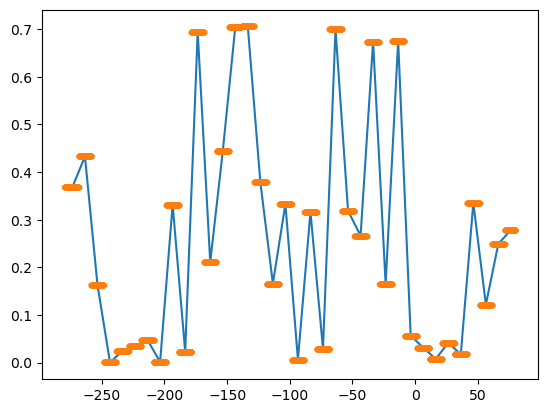

In [103]:
# get lat/lon on contour to interp onto:
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0)
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0)

# first fix lon dimension on r^2:
r_sq_annual_10deg['lon_bins'] = r_sq_annual_10deg.lon_bins

# now interpolate onto lon_along_contour:
r_sq_annual_10deg_interp = r_sq_annual_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_annual_10deg.lon_bins,r_sq_annual_10deg,'.-')
plt.plot(r_sq_annual_10deg_interp.lon_bins,r_sq_annual_10deg_interp,'.')

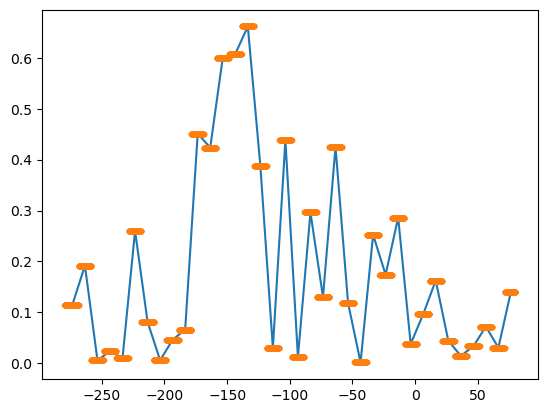

In [104]:
# first fix lon dimension on r^2:
r_sq_all_10deg['lon_bins'] = r_sq_all_10deg.lon_bins

# now interpolate onto lon_along_contour:
r_sq_all_10deg_interp = r_sq_all_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_all_10deg.lon_bins,r_sq_all_10deg,'.-')
plt.plot(r_sq_all_10deg_interp.lon_bins,r_sq_all_10deg_interp,'.')

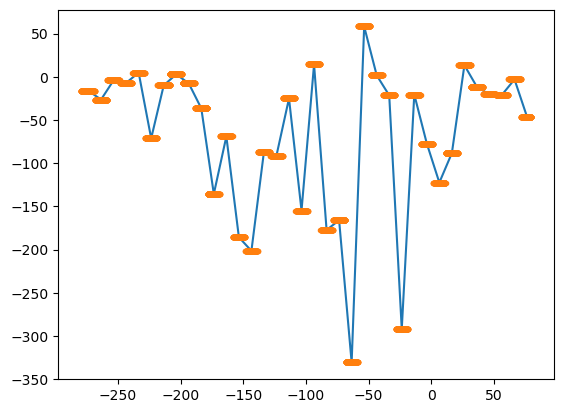

In [105]:
# first fix lon dimension on r^2:
slope_sq_all_10deg['lon_bins'] = slope_sq_all_10deg.lon_bins

# now interpolate onto lon_along_contour:
slope_sq_all_10deg_interp = slope_sq_all_10deg.interp(lon_bins=CSHT_lon_along_contour, \
                                                      method='nearest',kwargs={"fill_value": "extrapolate"})
# plot to check:
plt.plot(slope_sq_all_10deg.lon_bins,slope_sq_all_10deg,'.-')
plt.plot(slope_sq_all_10deg_interp.lon_bins,slope_sq_all_10deg_interp,'.')

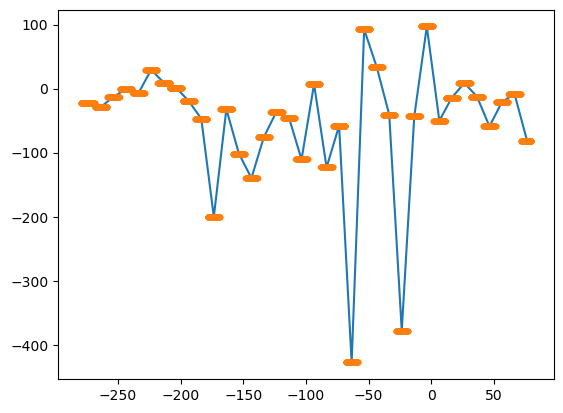

In [106]:

# first fix lon dimension on r^2:
slope_sq_annual_10deg['lon_bins'] = slope_sq_annual_10deg.lon_bins

# now interpolate onto lon_along_contour:
slope_sq_annual_10deg_interp = slope_sq_annual_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(slope_sq_annual_10deg.lon_bins,slope_sq_annual_10deg,'.-')
plt.plot(slope_sq_annual_10deg_interp.lon_bins,slope_sq_annual_10deg_interp,'.')

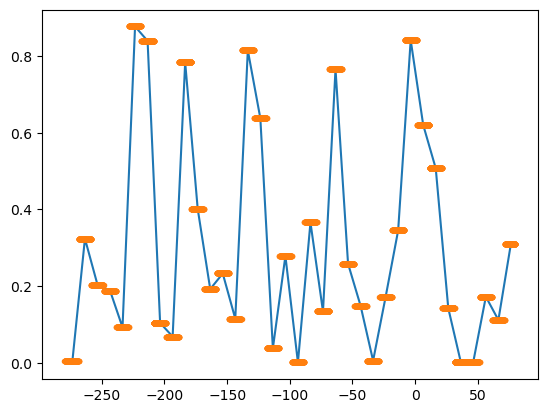

In [107]:
# first fix lon dimension on r^2:
r_sq_clima_10deg['lon_bins'] = r_sq_clima_10deg.lon_bins

# now interpolate onto lon_along_contour:
r_sq_clima_10deg_interp = r_sq_clima_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_clima_10deg.lon_bins,r_sq_clima_10deg,'.-')
plt.plot(r_sq_clima_10deg_interp.lon_bins,r_sq_clima_10deg_interp,'.')

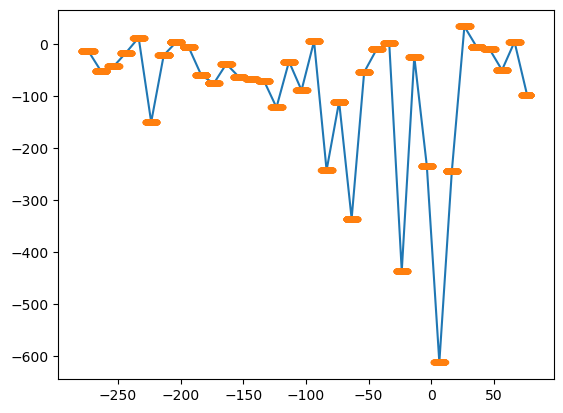

In [108]:
# first fix lon dimension on r^2:
slope_sq_clima_10deg['lon_bins'] = slope_sq_clima_10deg.lon_bins

# now interpolate onto lon_along_contour:
slope_sq_clima_10deg_interp = slope_sq_clima_10deg.interp(lon_bins=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(slope_sq_clima_10deg.lon_bins,slope_sq_clima_10deg,'.-')
plt.plot(slope_sq_clima_10deg_interp.lon_bins,slope_sq_clima_10deg_interp,'.')

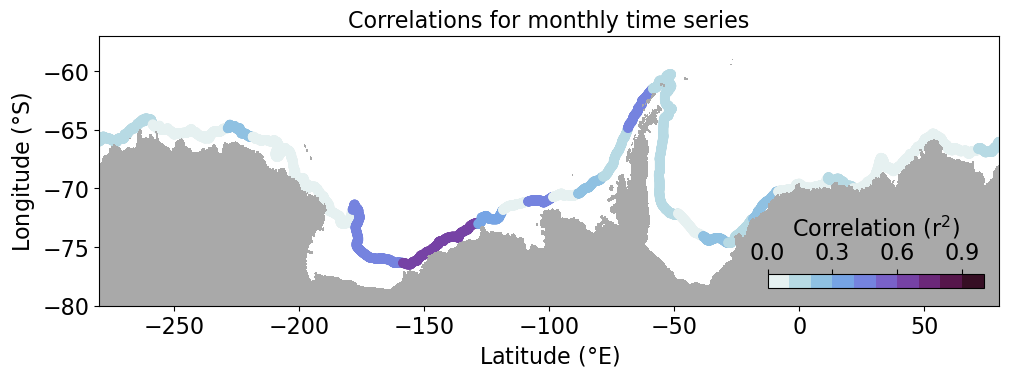

In [109]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_all_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
ax_cric.set_title('Correlations for monthly time series',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

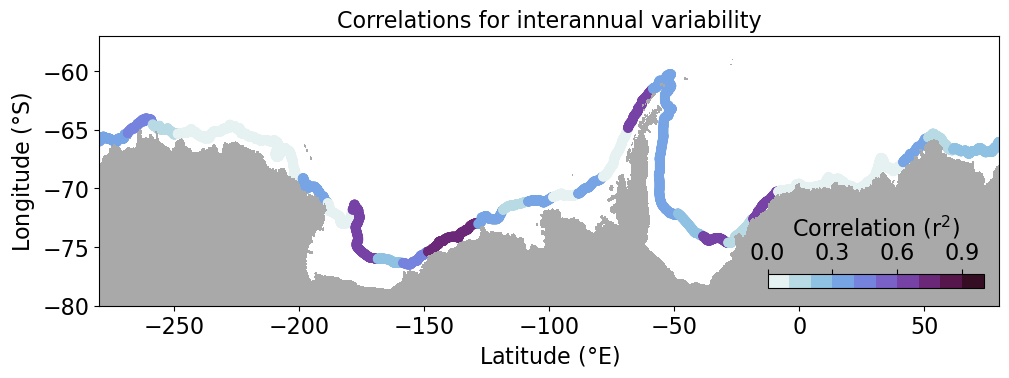

In [110]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_annual_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
ax_cric.set_title('Correlations for interannual variability',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

In [118]:
def subplot_corr_along_contour(subplot_ax, quantity, type_quantity):
    ax_cric = subplot_ax#.add_axes([0,0,0.9,.9])

    if type_quantity == 'corr':
        scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap = discrete_cmap(10, cmocean.dense), 
                               vmin = 0, vmax = 1)
    elif type_quantity == 'slope':
        scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = quantity, cmap =custom_cmap_slope, 
                       vmin = -300,vmax =300) # 150 for cric
    ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
    ax_cric.set_ylim([-80,-57])
    ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
    ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
    ax_cric.set_title(quantity.name,fontsize=fontsize)
    ax_cric.tick_params(labelsize=fontsize)
    
    axins1 = inset_axes(
        ax_cric,
        width="24%",  # width: 50% of parent_bbox width
        height="5%", # height: 5%
        loc='lower left',
        bbox_to_anchor = (0.735,0.04,1,1),
        bbox_transform=ax_cric.transAxes)
    cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
    
    if type_quantity == 'corr':
        cb.set_ticks([0,0.3,0.6,.9])
        cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
        
    elif type_quantity == 'slope':
        cb.set_label('Slope (TW/(m/s))',fontsize=fontsize)


    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position("top")
    cb.ax.tick_params(labelsize=fontsize)
    return

In [112]:
r_sq_all_10deg_interp.name

'r_sq_all'

In [83]:
# assigining numbers by regime clustering mask
import matplotlib
colorsList_no3 = [('mediumseagreen'),('tomato'),('blueviolet')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

clustering_mask = xr.open_mfdataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')
clustering_mask_sum = xr.concat([clustering_mask.regimes_mask.isel(regime = reg_no) * (reg_no+1) for reg_no in range(3)], dim = 'regime').sum(dim = 'regime')
clustering_mask_sum

<xarray.DataArray 'regimes_mask' (lon: 1428)> Size: 11kB
dask.array<sum-aggregate, shape=(1428,), dtype=float64, chunksize=(1428,), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 11kB -278.5 -278.2 -278.0 -277.8 ... 77.75 78.0 78.25

In [84]:
import matplotlib.colors as mcolors

def custom_curl_cmap():
    # Get the original cmocean.cm.curl colormap
    original_cmap = cmocean.curl

    # Create a new colormap by adding a white band around zero
    # We define the number of colors for the colormap
    num_colors = 256

    # Create the original colormap and a new one for white band
    new_colors = original_cmap(np.linspace(0, 1, num_colors))

    # Define the position of the white band
    mid_point = num_colors // 2  # Middle index
    band_width = round(0.1*256)  # Width of the white band -- middle 10% of range

    # Set the colors in the middle to white
    new_colors[mid_point - band_width//2 : mid_point + band_width//2] = [1, 1, 1, 1]  # RGBA for white

    # Create a new colormap from the modified color array
    custom_cmap = mcolors.ListedColormap(new_colors)

    return custom_cmap

In [85]:
custom_cmap_slope = custom_curl_cmap()

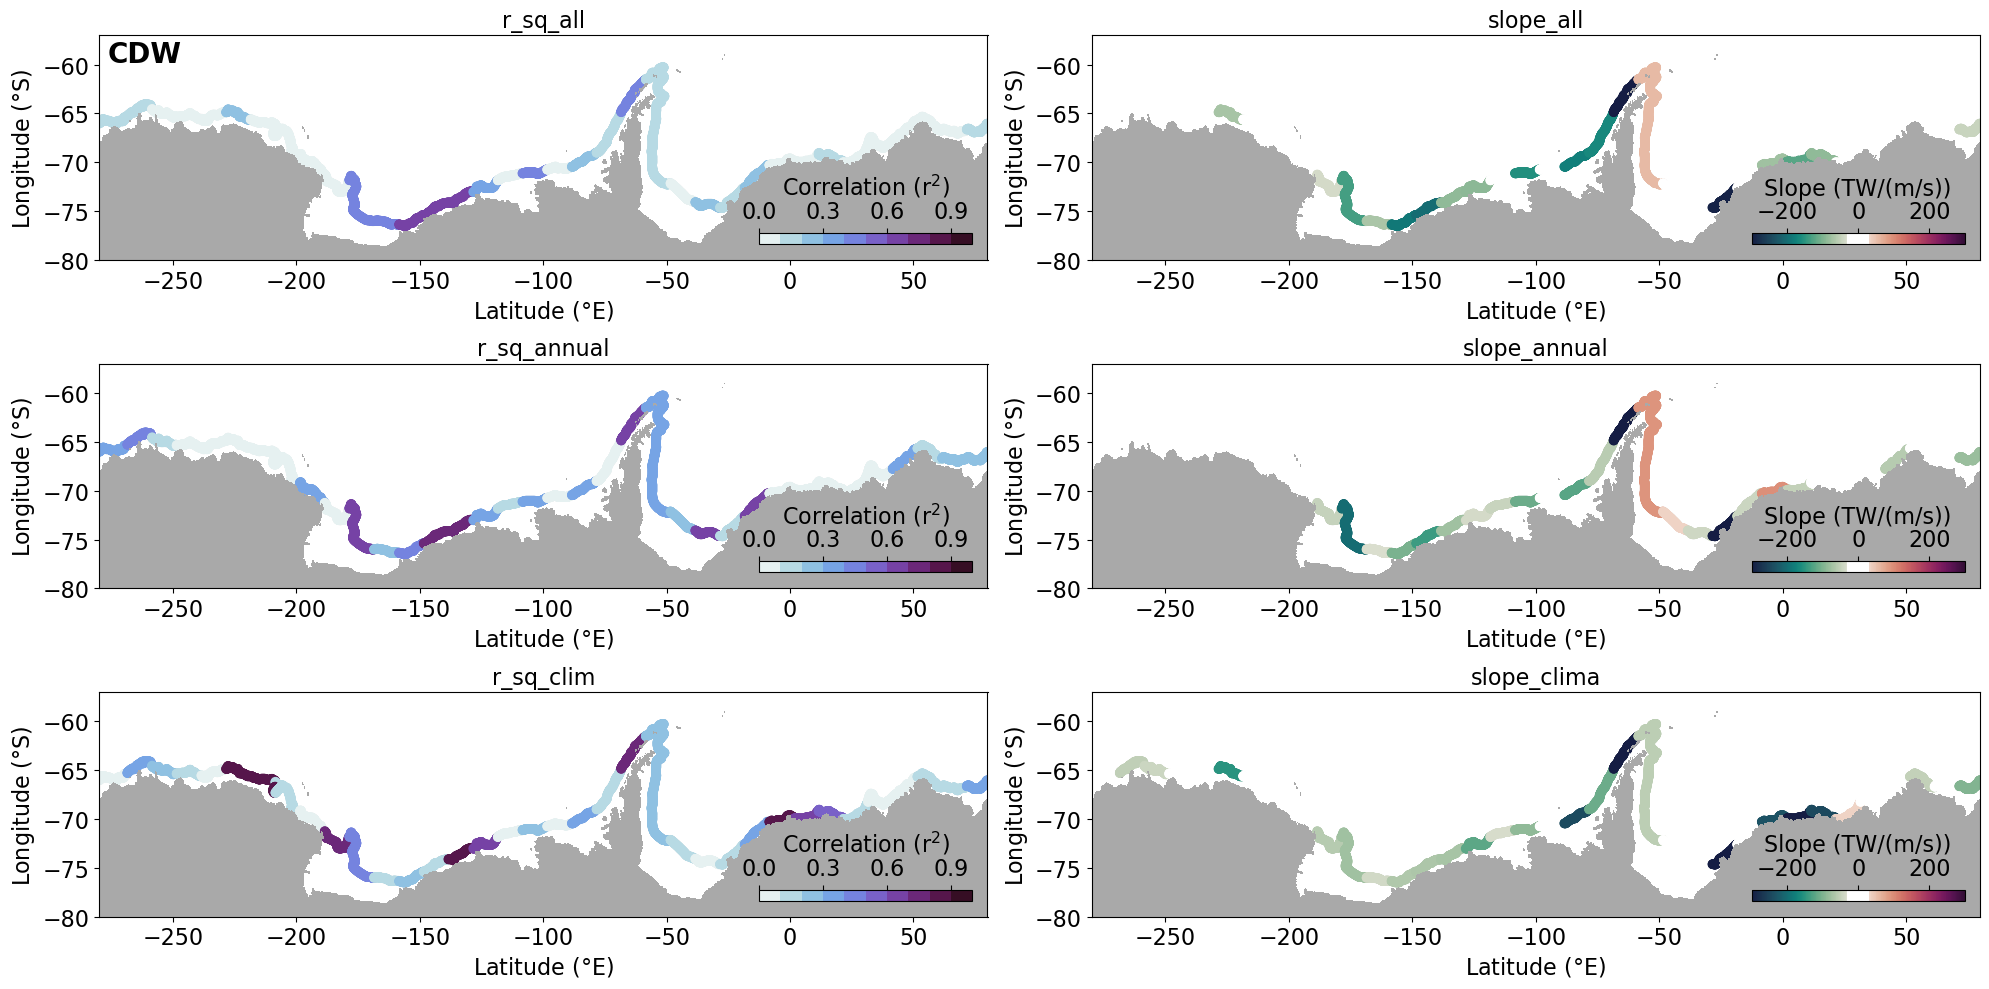

In [119]:
fig, ax = plt.subplots(nrows = 3,ncols = 2,figsize = (20, 10))
subplot_corr_along_contour(ax[0,0],r_sq_all_10deg_interp, 'corr')
subplot_corr_along_contour(ax[1,0],r_sq_annual_10deg_interp, 'corr')
subplot_corr_along_contour(ax[2,0],r_sq_clima_10deg_interp, 'corr')
subplot_corr_along_contour(ax[0,1],slope_sq_all_10deg_interp, 'slope')
subplot_corr_along_contour(ax[1,1],slope_sq_annual_10deg_interp, 'slope')
subplot_corr_along_contour(ax[2,1],slope_sq_clima_10deg_interp, 'slope')
#ax[0,0].pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3, alpha = 0.5)
#ax[0,1].pcolormesh(clustering_mask.lon, [-58,-57],  np.vstack((clustering_mask_sum,clustering_mask_sum)) , cmap=CustomCmap_no3, alpha = 0.5)
ax[0,0].text(0.01,0.88, 'CDW' ,transform=ax[0,0].transAxes, fontsize = 20, fontweight = 'bold')

## adjust colorbar so middle is white

## CLIMATOLOGY ONLY HAS 12 point because monthly data used for age
plt.tight_layout()
### NB negative slope means that weaker westward current --> more southward CSHT
### positive slope means that stronger westward current --> more southward CSHT , if eastward current, stronger currentm

Text(0.01, 0.01, 'Climatology')

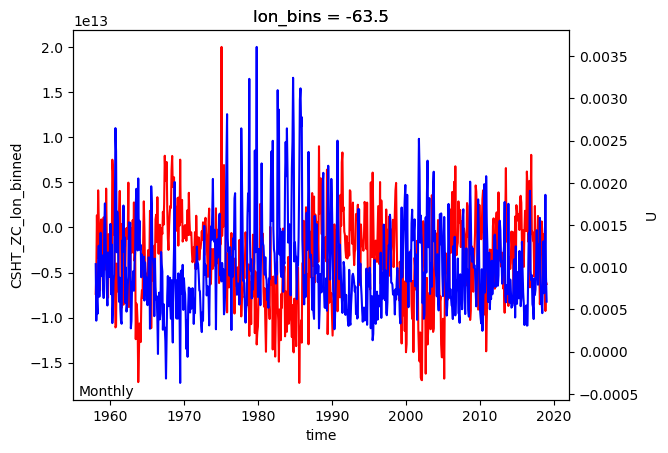

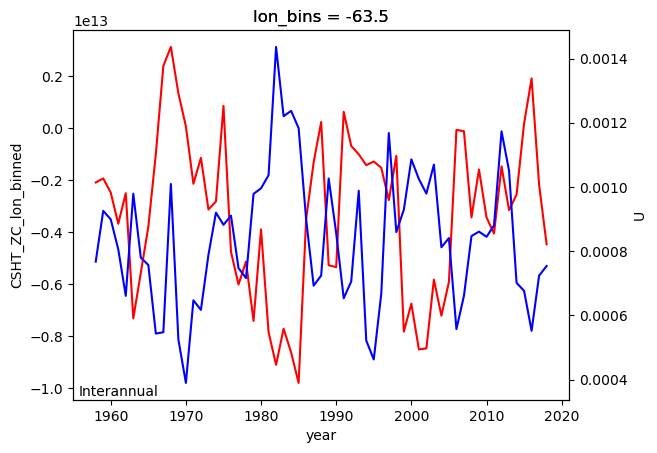

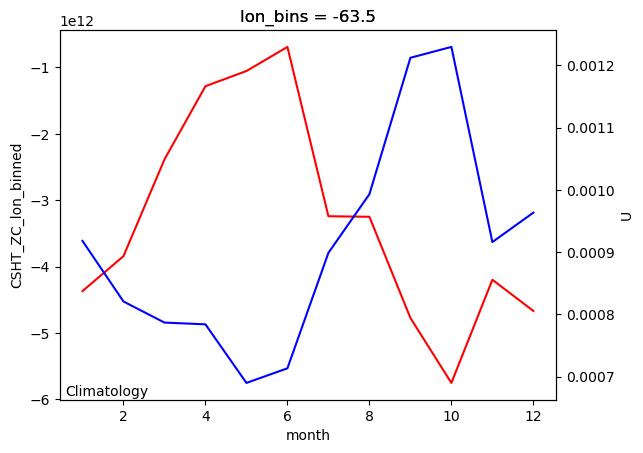

In [39]:
## Checking time series: Ross ---> high correlation negative slope region
'''
U_along_layerwise_binned_CDW.U, U_along_annual_binned_CDW.U, U_along_clima_binned_CDW.U,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_CDW.CSHT_ZC_lon_binned
'''
lon_test = -60
fig, ax = plt.subplots()
CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins = lon_test, method = 'nearest').plot(color = 'r')
ax2 = ax.twinx()
U_along_layerwise_binned_CDW.U.sel(lon_bins = lon_test, method = 'nearest').plot(ax = ax2, color = 'b')
ax.text(0.01,0.01,'Monthly',transform=ax.transAxes)


fig, ax = plt.subplots()
CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins = lon_test, method = 'nearest').plot(color = 'r')
ax2 = ax.twinx()
U_along_annual_binned_CDW.U.sel(lon_bins = lon_test, method = 'nearest').plot(ax = ax2, color = 'b')
ax.text(0.01,0.01,'Interannual',transform=ax.transAxes)

fig, ax = plt.subplots()
CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins = lon_test, method = 'nearest').plot(color = 'r')
ax2 = ax.twinx()
U_along_clima_binned_CDW.U.sel(lon_bins = lon_test, method = 'nearest').plot(ax = ax2, color = 'b')
ax.text(0.01,0.01,'Climatology',transform=ax.transAxes)



Text(0.01, 0.01, 'Climatology')

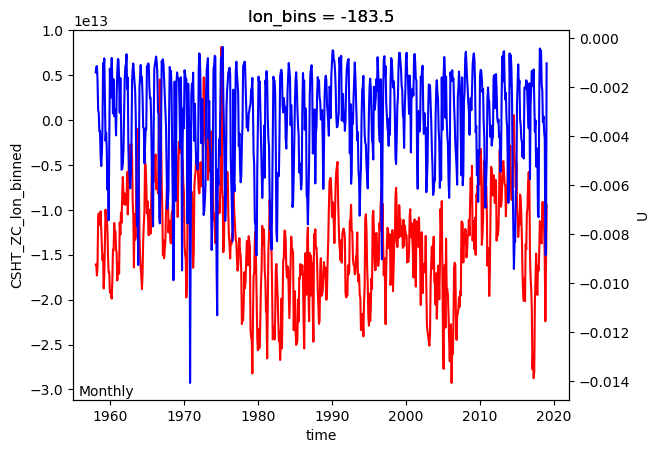

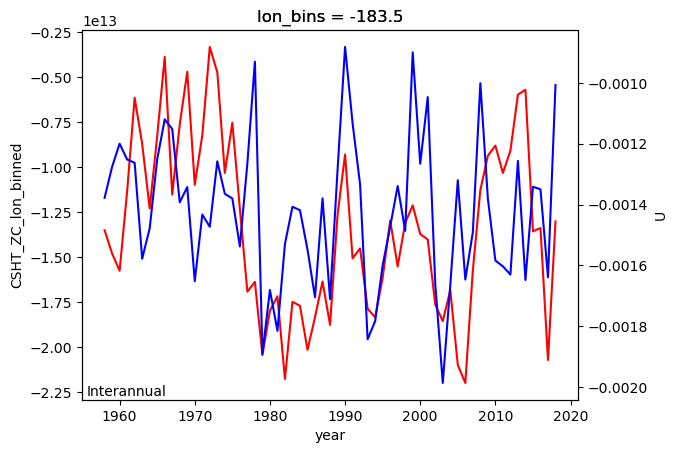

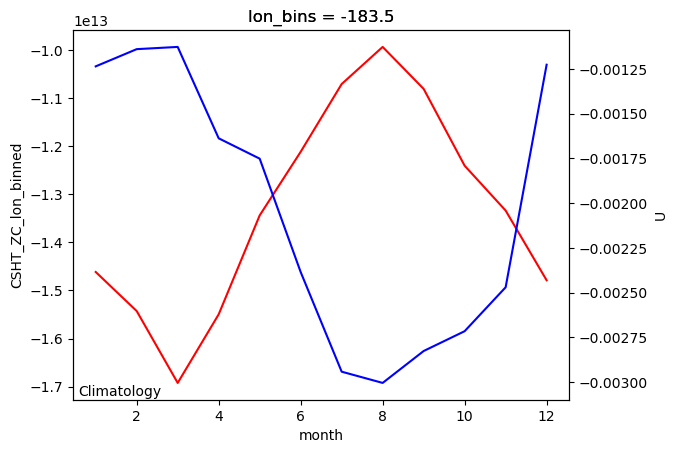

In [37]:
## Checking time series: Ross ---> high correlation negative slope region
'''
U_along_layerwise_binned_CDW.U, U_along_annual_binned_CDW.U, U_along_clima_binned_CDW.U,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_CDW.CSHT_ZC_lon_binned
'''
lon_test = -180
fig, ax = plt.subplots()
CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins = lon_test, method = 'nearest').plot(color = 'r')
ax2 = ax.twinx()
U_along_layerwise_binned_CDW.U.sel(lon_bins = lon_test, method = 'nearest').plot(ax = ax2, color = 'b')
ax.text(0.01,0.01,'Monthly',transform=ax.transAxes)


fig, ax = plt.subplots()
CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins = lon_test, method = 'nearest').plot(color = 'r')
ax2 = ax.twinx()
U_along_annual_binned_CDW.U.sel(lon_bins = lon_test, method = 'nearest').plot(ax = ax2, color = 'b')
ax.text(0.01,0.01,'Interannual',transform=ax.transAxes)

fig, ax = plt.subplots()
CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins = lon_test, method = 'nearest').plot(color = 'r')
ax2 = ax.twinx()
U_along_clima_binned_CDW.U.sel(lon_bins = lon_test, method = 'nearest').plot(ax = ax2, color = 'b')
ax.text(0.01,0.01,'Climatology',transform=ax.transAxes)



Text(0.01, 0.01, 'Climatology')

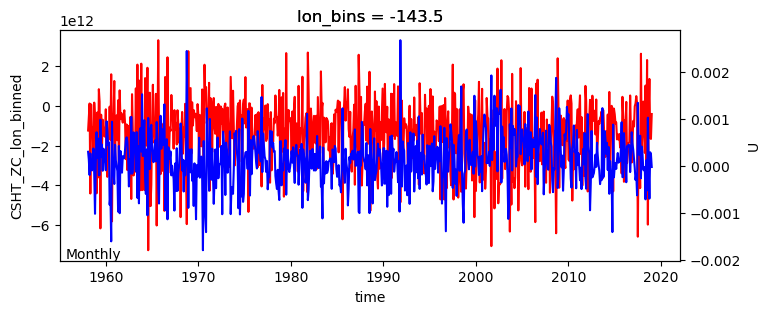

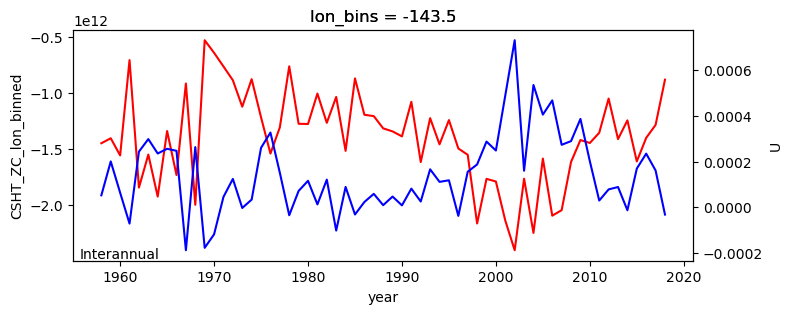

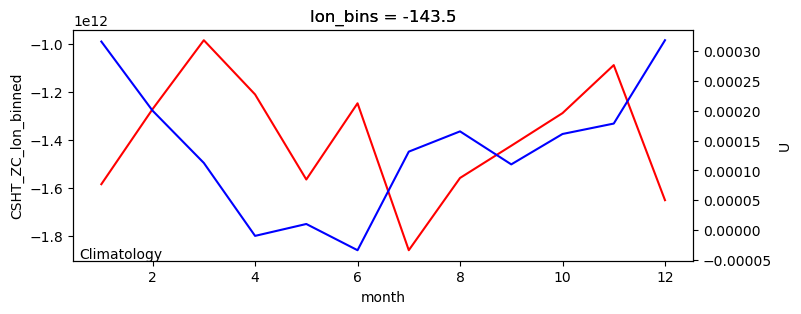

In [41]:
## Checking time series: adelie overflow/ Totten ---> high correlation (except climatology) negative slope region
'''
U_along_layerwise_binned_CDW.U, U_along_annual_binned_CDW.U, U_along_clima_binned_CDW.U,\
                    CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned, CSHT_annual_binned_CDW.CSHT_ZC_lon_binned
                    , CSHT_clima_binned_CDW.CSHT_ZC_lon_binned
'''
lon_test = -140
fig, ax = plt.subplots(figsize = (8,3))
CSHT_layerwise_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins = lon_test, method = 'nearest').plot(color = 'r')
ax2 = ax.twinx()
U_along_layerwise_binned_CDW.U.sel(lon_bins = lon_test, method = 'nearest').plot(ax = ax2, color = 'b')
ax.text(0.01,0.01,'Monthly',transform=ax.transAxes)


fig, ax = plt.subplots(figsize = (8,3))
CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins = lon_test, method = 'nearest').plot(color = 'r')
ax2 = ax.twinx()
U_along_annual_binned_CDW.U.sel(lon_bins = lon_test, method = 'nearest').plot(ax = ax2, color = 'b')
ax.text(0.01,0.01,'Interannual',transform=ax.transAxes)

fig, ax = plt.subplots(figsize = (8,3))
CSHT_clima_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins = lon_test, method = 'nearest').plot(color = 'r')
ax2 = ax.twinx()
U_along_clima_binned_CDW.U.sel(lon_bins = lon_test, method = 'nearest').plot(ax = ax2, color = 'b')
ax.text(0.01,0.01,'Climatology',transform=ax.transAxes)



##### 

In [ ]:
## adele's code below

### Plot seasonal climatology correlations in CDW layer:

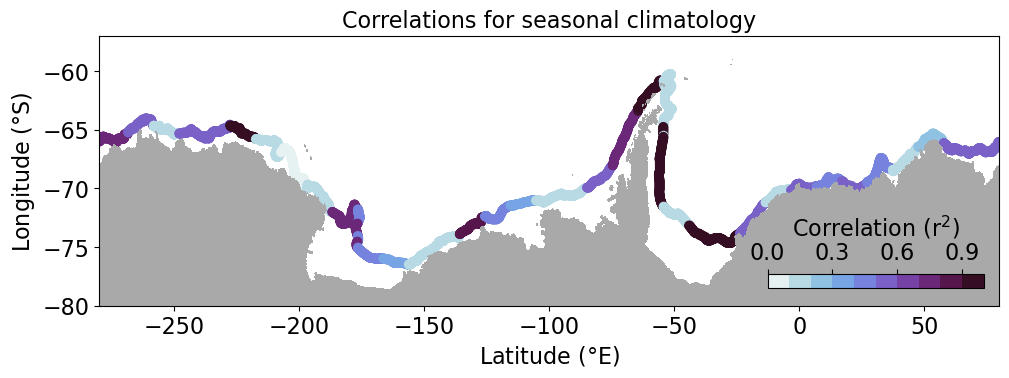

In [76]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_clima_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
ax_cric.set_title('Correlations for seasonal climatology',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

In [ ]:
## adele's code for high frequency correlations -->

### Then plot high frequency daily correlations in CDW layer:

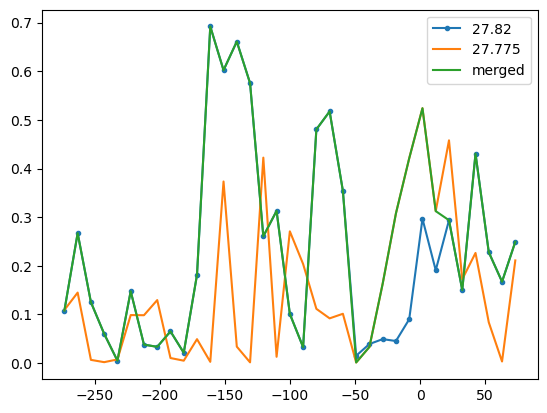

In [4]:
# Even though there are no missing longitude values for the CDW layer climatology, still replace, 
# because there is not much data/thickness in the CDW layer in eastern Weddell:
# Replace the 27.82 CDW layer with the lighter density layer above between ~-50 and ~10deg longitude.
# The time mean map of density in this region shows that the 27.82 layer doesn't exist at all in this longitude range.

plt.plot(r_sq_daily_10deg.lon_bins,r_sq_daily_10deg.sel(potrho0=27.82),'.-',label='27.82')
plt.plot(r_sq_daily_10deg.lon_bins,r_sq_daily_10deg.sel(potrho0=27.775),label='27.775')

r_sq_daily_10deg_CDWfixed = r_sq_daily_10deg.sel(potrho0=27.82)
missing_values = np.where((r_sq_daily_10deg.lon_bins.values > -50)&(r_sq_daily_10deg.lon_bins.values < 20))
r_sq_daily_10deg_CDWfixed[missing_values] = r_sq_daily_10deg.sel(potrho0=27.775)[missing_values]
plt.plot(r_sq_daily_10deg_CDWfixed.lon_bins,r_sq_daily_10deg_CDWfixed,label='merged')
plt.legend()

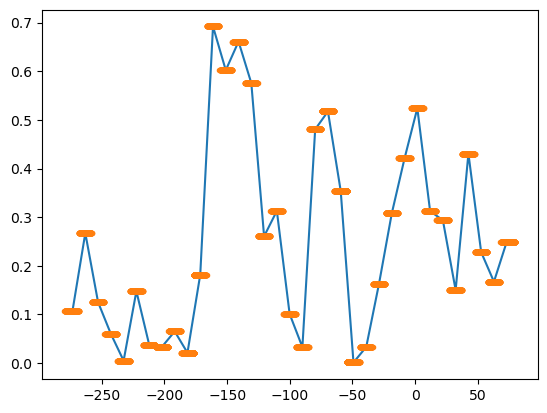

In [5]:
# interpolate longitude binned r^2 onto finer contour grid, so we can plot along contour nicely:

# get lat/lon on contour to interp onto:
CSHT_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/WMbins_daily_rho/*')
CSHT_lon_along_contour = CSHT_along.lon_along_contour.isel(time = 0)
CSHT_lat_along_contour = CSHT_along.lat_along_contour.isel(time = 0)

# first fix lon dimension on r^2:
r_sq_daily_10deg_CDWfixed['lon_bin_mid'] = r_sq_daily_10deg_CDWfixed.lon_bins

# now interpolate onto lon_along_contour:
r_sq_daily_10deg_interp = r_sq_daily_10deg_CDWfixed.interp(lon_bin_mid=CSHT_lon_along_contour,method='nearest',kwargs={"fill_value": "extrapolate"})

# plot to check:
plt.plot(r_sq_daily_10deg_CDWfixed.lon_bins,r_sq_daily_10deg_CDWfixed,'.-')
plt.plot(r_sq_daily_10deg_interp.lon_bin_mid,r_sq_daily_10deg_interp,'.')

### Plot high freq correlations in CDW layer:

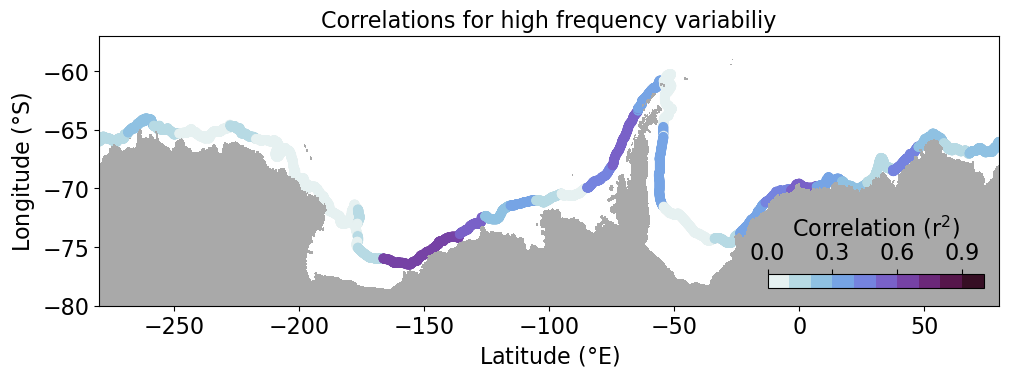

In [8]:
fontsize=16

fig = plt.figure(1,figsize = (10, 3))
ax_cric = fig.add_axes([0,0,0.9,.9])

scat = ax_cric.scatter(CSHT_lon_along_contour, CSHT_lat_along_contour,c = r_sq_daily_10deg_interp, cmap = discrete_cmap(10, cmocean.dense), 
                       vmin = 0, vmax = 1)
ax_cric.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
ax_cric.set_ylim([-80,-57])
ax_cric.set_ylabel('Longitude ($\degree$S)',fontsize=fontsize)
ax_cric.set_xlabel('Latitude ($\degree$E)',fontsize=fontsize)
ax_cric.set_title('Correlations for high frequency variabiliy',fontsize=fontsize)
ax_cric.tick_params(labelsize=fontsize)

axins1 = inset_axes(
    ax_cric,
    width="24%",  # width: 50% of parent_bbox width
    height="5%",  # height: 5%
    loc='lower left',
    bbox_to_anchor = (0.735,0.04,1,1),
    bbox_transform=ax_cric.transAxes)
cb = fig.colorbar(scat, cax = axins1, orientation = 'horizontal')#, label = 'Correlation (r$^2$)',fontsize=fontsize)
cb.set_label('Correlation (r$^2$)',fontsize=fontsize)
cb.set_ticks([0,0.3,0.6,.9])
cb.ax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.ax.tick_params(labelsize=fontsize)

In [ ]:
# to do next:
# 1. plot annual correlations with CDW layer CSHT but depth average ASC.

# can I get high frequency correlations? e.g. high pass filter. But then CDW layer won't exist a lot of the time.

